<a href="https://colab.research.google.com/github/nyirobalazs/multilayer_perceptron/blob/main/Multilayer_perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tqdm import tqdm 
from sklearn.datasets import fetch_openml
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
import time
import copy
import matplotlib.pyplot as plt

In [ ]:
class Data(object):

  def __init__(self):
      x_data, y_data = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
      x_data = (x_data/255).astype('float32')
      y_data = to_categorical(y_data)
      test_ratio = 0.14285714285714285714285714285714
      self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x_data, y_data, test_size=test_ratio, random_state=42)
      pass


In [ ]:
class Multilayer_Perceptron():
    def __init__(self, hid_unit_num, max_epoch, learn_rate, finish_mode, decay_mode, decay_rate, energy_scale_maintenance, req_acc, cons_mode, cons_th, minibatch_size):
        self.hid_unit_num = hid_unit_num
        self.max_epoch = max_epoch
        self.learn_rate = learn_rate
        self.learning_time = 1
        self.finish_mode = finish_mode
        self.permanent = {} #just to transfer IN&OUT values between forward and backward prop.
        self.decay_mode = decay_mode
        self.decay_rate = decay_rate
        self.energy_scale_maintenance = energy_scale_maintenance
        self.trans_energy = 0
        self.cons_energy = 0
        self.perc_energy = 0
        self.required_acc = req_acc
        self.cons_mode = cons_mode
        self.cons_treshold = cons_th
        self.save = {} # for testing
        self.minibatch_size = minibatch_size
        
        # save paramaters into a dictionary
        self.parameters_initial, self.parameters_persistent, self.parameters_transient, self.parameters_history, self.permanent = self.initialization()


    def __get_total_weights__(self):
        '''
        It gives back: total memory = initial - (transient + persistent)
        '''
        WT1_id = np.add(self.parameters_persistent['WT1'], self.parameters_transient['WT1'])
        WT2_id = np.add(self.parameters_persistent['WT2'], self.parameters_transient['WT2'])
        WT1_sum = np.subtract(self.parameters_initial['WT1'], WT1_id)
        WT2_sum = np.subtract(self.parameters_initial['WT2'], WT2_id)
        
        total_weights  = {
            'WT1' : WT1_sum,
            'WT2' : WT2_sum
        }

        return total_weights
    

    def __set_total_weights__(self):
        '''
        1. Total memory = initial - (transient + persistent)
        2. Refresh permanent memory
        '''
        
        WT1_id = np.add(self.parameters_persistent['WT1'], self.parameters_transient['WT1'])
        WT2_id = np.add(self.parameters_persistent['WT2'], self.parameters_transient['WT2'])
        WT1_sum = np.subtract(self.parameters_initial['WT1'], WT1_id)
        WT2_sum = np.subtract(self.parameters_initial['WT2'], WT2_id)
        self.permanent['WT1'] = WT1_sum
        self.permanent['WT2'] = WT2_sum


    def sigmoid_function(self, x, derivate=False):
        if derivate:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def synaptic_decay(self):
        '''
        Exponential decay with decay rate. new_weights = old_weights*(1-decay_rate)^predictation_timestep. It only does if decay mode is True.
        '''
        if self.decay_mode:
            self.parameters_transient['WT1'] *= np.power(np.exp(-self.decay_rate),1)
            self.parameters_transient['WT2'] *= np.power(np.exp(-self.decay_rate),1)

    def softmax_function(self, x, derivate=False):
        expons = np.exp(x - x.max())
        if derivate:
            return expons / np.sum(expons, axis=0) * (1 - expons / np.sum(expons, axis=0))
        return expons / np.sum(expons, axis=0)

    def trans_energy_calc(self):
        if self.cons_mode == "no_cons":
            self.trans_energy += 0
        else:
            self.trans_energy += self.energy_scale_maintenance * ( np.sum( np.fabs(self.parameters_transient['WT1'])) + np.sum( np.fabs(self.parameters_transient['WT2'])) )

    def min_energy_calc(self):
        current_weights = self.__get_total_weights__()
        difference_WT1 = current_weights['WT1'] - self.parameters_initial['WT1']
        difference_WT2 = current_weights['WT2'] - self.parameters_initial['WT2']
        min_energy = np.sum( np.fabs(difference_WT1)) + np.sum( np.fabs(difference_WT2))

        return min_energy

    def cons_energy_calc(self, weight_difference):
        self.cons_energy += np.sum( np.fabs(weight_difference['WT1'])) + np.sum( np.fabs(weight_difference['WT2']))  

    def perc_energy_calc(self, weight_change):
        self.perc_energy += np.sum( np.fabs(weight_change['WT1'])) + np.sum( np.fabs(weight_change['WT2']))        


    def consolidation(self):
        
        old_weights = copy.deepcopy(self.parameters_persistent)

        if self.cons_mode == "no_cons":
            self.parameters_persistent['WT1'] += self.parameters_transient['WT1']
            self.parameters_persistent['WT2'] += self.parameters_transient['WT2']
            self.parameters_transient['WT1'] = np.zeros((self.hidden_layer, self.input_layer))
            self.parameters_transient['WT2'] = np.zeros((self.output_layer, self.hidden_layer))


        elif self.cons_mode == "lc_th_lc_cons":
          for dict_indexes, dict_params in self.parameters_transient.items():
              for array_indexes, np_arrays in enumerate(dict_params):
                  for val_indexes, values in enumerate(np_arrays):
                    if np.fabs(values)>=self.cons_treshold: 
                      self.parameters_persistent[dict_indexes][array_indexes][val_indexes] += self.parameters_transient[dict_indexes][array_indexes][val_indexes]
                      self.parameters_transient[dict_indexes][array_indexes][val_indexes] = 0.00
        
        elif self.cons_mode == "lc_th_gl_cons":
          count_above_th = 0
          for dict_indexes, dict_params in self.parameters_transient.items():
              for array_indexes, np_arrays in enumerate(dict_params):
                  for val_indexes, values in enumerate(np_arrays):
                    if np.fabs(values)>=self.cons_treshold:
                      count_above_th += 1

          if count_above_th>0:
              self.parameters_persistent['WT1'] += self.parameters_transient['WT1']
              self.parameters_persistent['WT2'] += self.parameters_transient['WT2']
              self.parameters_transient['WT1'] = np.zeros((self.hidden_layer, self.input_layer))
              self.parameters_transient['WT2'] = np.zeros((self.output_layer, self.hidden_layer))

        elif self.cons_mode == "gl_th_gl_cons":
          count_above_th = 0
          count_len_dict = 0
          for dict_indexes, dict_params in self.parameters_transient.items():
              for array_indexes, np_arrays in enumerate(dict_params):
                  for val_indexes, values in enumerate(np_arrays):
                    count_len_dict += 1                    
                    if np.fabs(values)>=self.cons_treshold:
                      count_above_th += 1

          if count_above_th == count_len_dict:
              self.parameters_persistent['WT1'] += self.parameters_transient['WT1']
              self.parameters_persistent['WT2'] += self.parameters_transient['WT2']
              self.parameters_transient['WT1'] = np.zeros((self.hidden_layer, self.input_layer))
              self.parameters_transient['WT2'] = np.zeros((self.output_layer, self.hidden_layer))
          
        elif self.cons_mode_ != "lc_th_lc_cons" or self.cons_mode_ != "lc_th_gl_cons" or self.cons_mode_ != "gl_th_gl_cons" :
            raise ValueError("Not existing consoldation mode")
        else:
            raise ValueError("Value problem in the consolidation function")

        weight_difference = {
            'WT1' : self.parameters_persistent['WT1'] - old_weights['WT1'],
            'WT2' : self.parameters_persistent['WT2'] - old_weights['WT2']
        }
        self.cons_energy_calc(weight_difference)


    def initialization(self):
        '''
        Set number of nodes in layers
        '''

        self.input_layer = 784
        self.hidden_layer = self.hid_unit_num
        self.output_layer = 10

        parameters_initial = {
            'WT1':np.random.randn(self.hidden_layer, self.input_layer) * np.sqrt(1. / self.hidden_layer),
            'WT2':np.random.randn(self.output_layer, self.hidden_layer) * np.sqrt(1. / self.output_layer)
        }

        parameters_persistent = {
            'WT1':np.zeros((self.hidden_layer, self.input_layer)),
            'WT2':np.zeros((self.output_layer, self.hidden_layer))
        }

        parameters_transient = {
            'WT1':np.zeros((self.hidden_layer, self.input_layer)),
            'WT2':np.zeros((self.output_layer, self.hidden_layer))
        }

        permanent = {}

        parameters_history = {
            'time': [],
            'epoch' : [],
            'accuracy' : [],
            'min_energy' : [],
            'con_energy' : [],
            'trans_energy': [],
            'perceptron_energy': [],
            'total_energy' : []
        }

        return parameters_initial, parameters_persistent, parameters_transient, parameters_history, permanent

    def forward_propagation(self, x_train):
        '''
        This is the forward propagation algorithm, for calculating the updates of 
        the neural network's parameters in the forward direction. It uses sigmoid
        funcion at the hidden layer and softmax at the output layer.
        '''
        
        self.__set_total_weights__()
        parameters_total = self.permanent

        # input layer activations becomes sample
        parameters_total['OUT_0'] = x_train

        # input layer to hidden layer 1
        parameters_total['IN_1'] = np.dot(parameters_total['WT1'], parameters_total['OUT_0'])
        parameters_total['OUT_1'] = self.sigmoid_function(parameters_total['IN_1'])

        # hidden layer 2 to output layer
        parameters_total['IN_2'] = np.dot(parameters_total['WT2'], parameters_total['OUT_1'])
        parameters_total['OUT_2'] = self.softmax_function(parameters_total['IN_2'])

        return parameters_total['OUT_2']

    def backpropagation(self, y_train, output):
        '''
        This is the backpropagation algorithm, for calculating the updates of 
        the neural network's parameters in the backward direction.
        '''

        parameters_total = self.permanent
        weight_change = {}

        # Calculate weight changes between the output and the hidden layer
        error = 2 * (output - y_train) / output.shape[0] * self.softmax_function(parameters_total['IN_2'], derivate=True)
        weight_change['WT2'] = np.outer(error, parameters_total['OUT_1'])

        # Calculate weight changes between the hidden layer and the input layer
        error = np.dot(parameters_total['WT2'].T, error) * self.sigmoid_function(parameters_total['IN_1'], derivate=True)
        weight_change['WT1'] = np.outer(error, parameters_total['OUT_0'])

        return weight_change


    def update_network(self, w_change):
        '''
        Update network parameters according to Stochastic Gradient Descent
        '''

        for ind, val in w_change.items():
            self.parameters_transient[ind] += self.learn_rate * val

       
    def compute_accuracy(self, x_test, y_test):
        '''
        This function performs a forward pass of x, then checks if the indices 
        of the output's highest value match the indices in the label y. After 
        that, it adds together all of the prediction and calculates the accuracy.
        '''

        pred = []

        for x__test_data, y__test_data in zip(x_test, y_test):
            output = self.forward_propagation(x__test_data)
            ind_pred = np.argmax(output)
            pred.append(ind_pred == np.argmax(y__test_data))
        
        return np.mean(pred)


    def train(self, x_train, y_train, x_test, y_test):
        '''
        This functions run through the epochs and call the forward, backward propagation
        and the weight update functions. After each epocs it calculates an accuracy.
        '''

        start_time = time.time()
        for iter in range(self.max_epoch):
            print()
            print(f"Processing epoch: {iter+1}/{self.max_epoch} --> ", end = ' ')
            for ind_train_pic,ind_train_label in tqdm(zip(x_train, y_train), total = x_train.shape[0]):
                self.learning_time +=1
                output = self.forward_propagation(ind_train_pic)
                w_change = self.backpropagation(ind_train_label, output)
                self.update_network(w_change)
                self.perc_energy_calc(w_change)
                self.trans_energy_calc()

                if(((self.learning_time+1)%self.minibatch_size)==0):
                    min_energy = self.min_energy_calc()
                    total_energy = self.trans_energy + self.cons_energy + self.perc_energy
                    batch_accuracy = self.compute_accuracy(x_test, y_test)
                    self.synaptic_decay()
                    self.consolidation()

                    self.parameters_history['time'].append(self.learning_time)
                    self.parameters_history['epoch'].append(iter)
                    self.parameters_history['accuracy'].append(batch_accuracy)
                    self.parameters_history['min_energy'].append(min_energy)
                    self.parameters_history['con_energy'].append(self.cons_energy)
                    self.parameters_history['trans_energy'].append(self.trans_energy)
                    self.parameters_history['total_energy'].append(total_energy)
                    self.parameters_history['perceptron_energy'].append(self.perc_energy)

                    if batch_accuracy >= self.required_acc and self.finish_mode == "success_rate": 
                        return self.parameters_history
                    elif batch_accuracy < self.required_acc and self.finish_mode == "till_the_end":
                        pass                    

                else:
                    self.synaptic_decay()
                    self.trans_energy_calc()
                    pass

            accuracy = self.compute_accuracy(x_test, y_test)
            print("\033[94m Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}% \033[0m".format(
                iter+1, time.time() - start_time, accuracy * 100
            ))

            # if it learned the data it interrupts the run.
            #if accuracy >= self.required_acc and self.finish_mode == "success_rate": 
            #    return iter, self.learning_time
            #elif accuracy < self.required_acc and self.finish_mode == "till_the_end":
            #    pass
            
            

In [27]:
MAX_EPOCH = 2 #normaly =30
HIDDEN_LAYER_UNITT_NUM = 100 #normaly = 100
LEARNING_RATE = 0.1 #normaly = 0.1
FINISH_MODE =  "till_the_end" # 1.till_the_end 2. success_rate
DECAY_MODE = True # True if there is a decay, and False if there is no decay
DECAY_RATE = 0.000001 #normaly = 0.001
ENERGY_SCALE_MAINTENANCE = 0.001
REQUIRED_ACCURACY = 100.0
CONSOLIDATION_MODE = "lc_th_lc_cons" # 1. lc_th_lc_cons 2. lc_th_gl_cons 3. gl_th_gl_cons 4. no_cons
CONSOLIDATION_TRESHOLD = 0.01 #normaly =0.01
MINIBATCH_SIZE = 10000

print("\033[1m Data initialization in progress... \033[0m")
dat = Data()
print('Done')

 Data initialization in progress... 
Done


In [28]:
#learning_rate_array = [0.001, 0.01, 0.1, 0.5]
learning_rate_array = [0.01]
histories = []
for LEARNING_RATE in learning_rate_array:
    mlp = Multilayer_Perceptron(HIDDEN_LAYER_UNITT_NUM, 
                                MAX_EPOCH, 
                                LEARNING_RATE, 
                                FINISH_MODE, 
                                DECAY_MODE, 
                                DECAY_RATE, 
                                ENERGY_SCALE_MAINTENANCE, 
                                REQUIRED_ACCURACY, 
                                CONSOLIDATION_MODE, 
                                CONSOLIDATION_TRESHOLD,
                                MINIBATCH_SIZE
                                )
 
    print("\033[1m Perceptron initialization done ==> " + f"Max epoch: {MAX_EPOCH} | Number of hidden units: {HIDDEN_LAYER_UNITT_NUM} | Learning rate: {LEARNING_RATE} | Consolidation mode: {CONSOLIDATION_MODE} | Stop accuracy: {REQUIRED_ACCURACY}  \033[0m")
    mlp.train(dat.x_train, dat.y_train, dat.x_test, dat.y_test)
    histories.append(mlp.parameters_history)

 Perceptron initialization done ==> Max epoch: 2 | Number of hidden units: 100 | Learning rate: 0.01 | Consolidation mode: lc_th_lc_cons | Stop accuracy: 100.0  

Processing epoch: 1/2 -->  

100%|██████████| 60000/60000 [03:04<00:00, 324.36it/s]


 Epoch: 1, Time Spent: 189.21s, Accuracy: 78.11% 

Processing epoch: 2/2 -->  

100%|██████████| 60000/60000 [03:01<00:00, 330.70it/s]


 Epoch: 2, Time Spent: 374.97s, Accuracy: 80.63% 


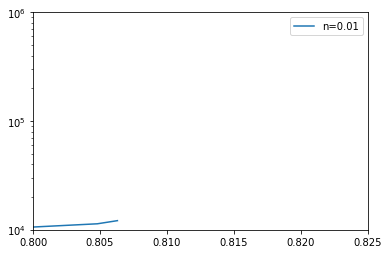

In [31]:
for ind, val in enumerate(histories):
  line_name = 'n=' + str(learning_rate_array[ind])
  y = np.multiply(histories[ind]['total_energy'],0.01)
  plt.plot(histories[ind]['accuracy'], y, label = line_name)

plt.ylim((10000, 1000000))
plt.xlim((0.8, 0.825))
plt.yscale("log")
plt.legend()
plt.show()